### Примеры решения задач сетевой оптимизации:
 1. Нахождения максимального потока
 2. Нахождения потока с минимальной стоимостью заданной величины $\theta$

In [1]:
import os
import sys
import copy
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

#### Максимальный поток

In [2]:
def find_max_flow(mat, labeldict, s, t):
    
    G = nx.DiGraph()
    G.add_edges_from(mat)
    
    # Рисуем граф
    nx.draw_networkx(G, labels = labeldict, with_labels = True)
    
    # Максимальный поток заданной сети
    # В параметрах ставим граф сети G, точку начала и конца потока.
    flow_value, flow_dict = nx.maximum_flow(G, s, t)
    min_cut = nx.minimum_edge_cut(G, s, t)
    minimum_cut_value = nx.minimum_cut_value(G, _s = s, _t = t)
    return flow_value, flow_dict, min_cut, minimum_cut_value


 47 
 {1: {2: 23, 3: 24}, 2: {3: 5, 4: 18}, 3: {5: 32}, 4: {3: 3, 6: 15}, 5: {4: 0, 6: 32}, 6: {}} 
 {(5, 6), (4, 6)} 
 47


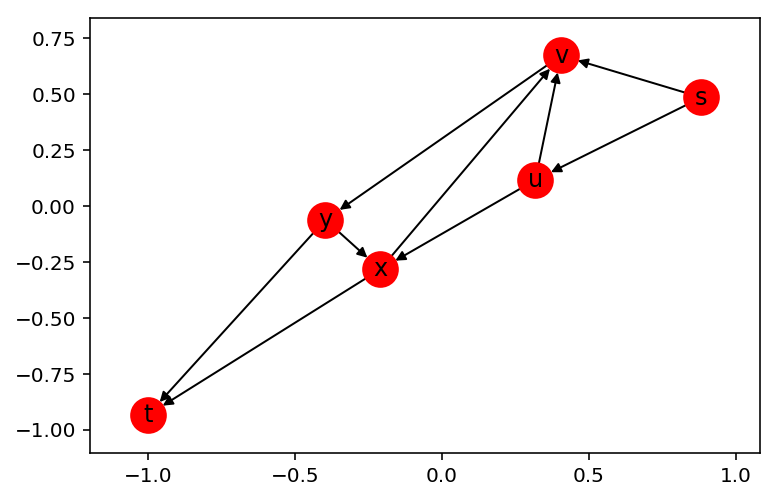

In [3]:
# Тестовый пример 1

labeldict = {1:'s', 2:'u', 3:'v', 4:'x', 5:'y', 6:'t'}
mat = [ (1, 2, {'capacity': 25}),
        (1, 3, {'capacity': 24}),
        (2, 3, {'capacity': 7}),
        (2, 4, {'capacity': 18}),
        (4, 3, {'capacity': 6}),
        (3, 5, {'capacity': 32}),
        (5, 4, {'capacity': 3}),
        (4, 6, {'capacity': 15}),
        (5, 6, {'capacity': 40})
       ]

flow_value, flow_dict, mincut, mincut_value = find_max_flow(mat, labeldict, 1, 6)
print('\n',flow_value,'\n',flow_dict,'\n',mincut,'\n',mincut_value)


 8 
 {1: {2: 3, 3: 5}, 2: {3: 0, 4: 3, 5: 0}, 3: {5: 5}, 4: {3: 0, 6: 3}, 5: {4: 0, 6: 5}, 6: {}} 
 {(5, 6), (4, 6)} 
 8


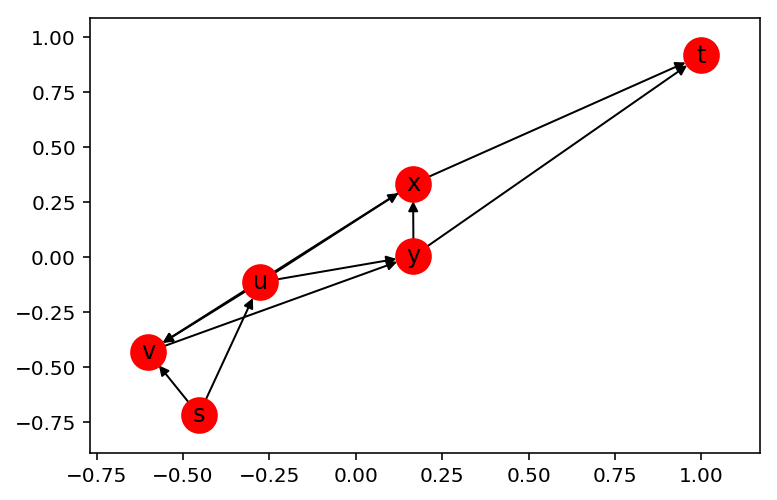

In [4]:
# Тестовый пример 2

labeldict = {1:'s', 2:'u', 3:'v', 4:'x', 5:'y', 6:'t'}
mat2  = [   (1, 2, {'capacity': 3}),
            (1, 3, {'capacity': 5}),
            (2, 3, {'capacity': 6}),
            (2, 4, {'capacity': 3}),
            (2, 5, {'capacity': 4}),
            (3, 5, {'capacity': 7}),
            (4, 3, {'capacity': 3}),
            (4, 6, {'capacity': 10}),
            (5, 4, {'capacity': 14}),
            (5, 6, {'capacity': 18})
           ]

flow_value, flow_dict, mincut, mincut_value = find_max_flow(mat2, labeldict, 1, 6)
print('\n',flow_value,'\n',flow_dict,'\n',mincut,'\n',mincut_value)


 19 
 {1: {2: 9, 3: 10}, 2: {3: 9, 4: 0, 5: 0}, 3: {4: 0, 5: 0, 6: 19}, 4: {6: 0}, 5: {6: 0}, 6: {}} 
 {(1, 2), (1, 3)} 
 19


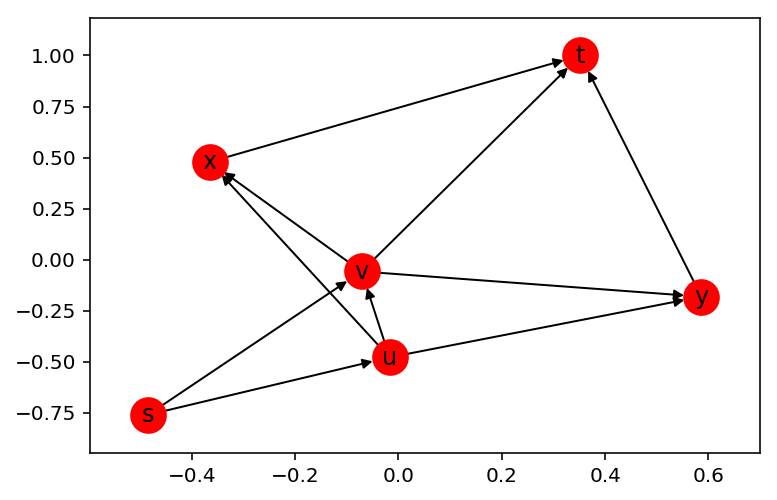

In [5]:
# Тестовый пример 3

labeldict = {1:'s', 2:'u', 3:'v', 4:'x', 5:'y', 6:'t'}
mat3  = [   (1, 2, {'capacity': 9}),
            (1, 3, {'capacity': 10}),
            (2, 3, {'capacity': 12}),
            (2, 4, {'capacity': 10}),
            (2, 5, {'capacity': 11}),
            (3, 4, {'capacity': 9}),
            (3, 5, {'capacity': 14}),
            (3, 6, {'capacity': 21}),
            (4, 6, {'capacity': 19}),
            (5, 6, {'capacity': 20})
        ]

flow_value, flow_dict, mincut, mincut_value = find_max_flow(mat3, labeldict, 1, 6)
print('\n',flow_value,'\n',flow_dict,'\n',mincut,'\n',mincut_value)

#### Расчет потока минимальной стоимости величиной $\theta$  для T-сети на основе алгоритма Broeseker-Gowen

In [6]:
class BroesekerGowenMinCost(object):
    def __init__(self, weights, capacity, flows, node_dict, source, target):
        super(BroesekerGowenMinCost, self).__init__()
        self.weights = weights
        self.capacity = capacity
        self.flows = flows
        self.capacity_default = copy.deepcopy(self.capacity)
        self.weights_default = copy.deepcopy(self.weights)
        
        self.node_dict = node_dict
        self.source = source
        self.target = target
        
        self.MU_CODE = '\u03BC'
        self.SMALL_DELTA_CODE = '\u03B4'
        self.THETA_CODE = '\u03B8'
        self.NU_CODE = '\u03BD'
        self.PHI_CODE = '\u03C6'
        
    def return_tuple(self, node1, node2, capacity_, weight):
        return (node1, node2, {'capacity': capacity_, 'weight':weight})
    
    def return_pregraph(self, capacity_ ,weights):
        pregraph = []
        for i,(row_cap, row_w) in enumerate(zip(capacity_, weights)):
            for j,(cap_elem, w_elem) in enumerate(zip(row_cap, row_w)):
                if cap_elem > 0:
                    pregraph.append(self.return_tuple(i+1, j+1, cap_elem, w_elem))
        return pregraph
    
    def bellman_ford(self, pregraph, source, target):
        graph = nx.DiGraph()
        graph.add_edges_from(pregraph)
        return nx.bellman_ford_path(graph, source = source, target = target)
    
    def get_shortest_path(self, capacity_, weights, source, target):
        pregraph = self.return_pregraph(capacity_ ,weights)
        return self.bellman_ford(pregraph, source, target)
    
    def get_min_by_shortest_path(self, capacity_, weights, flows, source, target): 
    
        # Кратчайший путь по алгоритму Беллмана-Форда
        shortest_path = self.get_shortest_path(capacity_, weights, source, target)   
        # Список потоковых значений по кратчайшему пути
        values = []
        # Координаты перехода (x,y) по узлам кратчайшего пути
        coords = []
        for i in range(len(shortest_path)-1):
            coords.append((shortest_path[i]-1, shortest_path[i+1]-1))
            values.append(capacity_[coords[i]])

        return coords, values
    
    def find_min_value(self, coords, values):
        min_val = min(values)
        index = values.index(min_val)
        coord = coords[index]
        # Получаем минимальное значение capacity
        # Коррдинаты этого значения в матрице
        # Все координаты заданной траектории
        return min_val, coord, coords
    
    
    def update_capacity_flows_mat(self, cap_default, capacity_, flows, weights, coord, coords, **kwargs):
    
        min_value = kwargs.get('min_value')

        #  Если min_value == None, взять знаение из матрицы, по умолчанию
        if min_value == None:
            min_value = capacity_[coord].copy()
        # Иначе взять значение из словаря kwargs
        else:
            pass
        capacity_copy = copy.deepcopy(capacity_)
        for c in coords:
            if weights[c] < 0:
                # Обновление прямых путей
                capacity_copy[c] -= min_value
                # Обновление обратных путей A_ji = A_ji += min_val + F_ij
                capacity_copy[c[1],c[0]] += min_value
            else:
                capacity_copy[c] = cap_default[c]
                capacity_copy[c] -= min_value
                capacity_copy[c] -= flows[c]

                capacity_copy[c[1],c[0]] = flows[c]
                capacity_copy[c[1],c[0]] += min_value

            # Обновление матрицы потоков сети
            flows[c] += min_value

        return capacity_copy, flows
    
    def update_weights_mat(self, weights, coord, coords):
        # Обратным дугам пути ставим отрицательную стоимость. 
        for c in coords:    
            weights[c[1],c[0]] = -weights[c] 
        # Ставим бесконечную цену насыщенному потоком узлу прямой дуги
        weights[coord] = np.inf
        return weights
    
    def check_total_vphi(self, total_vphi, min_val, theta):
        tmp_vphi = total_vphi + min_val
        if tmp_vphi <= theta:
            total_vphi = tmp_vphi
            min_val_dict = {'min_value': None}
            print(f'\tChecking flow value. Ok. tmp_phi: {tmp_vphi} <= {self.THETA_CODE}: {theta}. New total_vphi: {total_vphi}')
            return total_vphi, min_val, min_val_dict
        else:
            min_val = theta - total_vphi
            total_vphi = theta
            min_val_dict = {'min_value': min_val}
            print(f'\tChecking flow value. Warning. Possible new {self.NU_CODE}({self.PHI_CODE}): {tmp_vphi} > theta: {theta}. Min value set to {min_val}. New total_vphi: {total_vphi}')
            return total_vphi, min_val, min_val_dict
        
    def calculate_path_cost(self, weights, coords, mu):
        # Стоимость транспортировки единичного потока
        s = 0
        for c in coords:
            s+=weights[c]
        print(f'\tOne flow cost for the path d({mu}): {s}')
        
    def decode_path(self, node_list, node_dict):
        word_path = []
        for node in node_list:
            word_path.append(node_dict.get(node))
        return word_path
    
    def return_result(self):
        # Матица потоков
        tmp = self.capacity_default - self.capacity
        result_flows = np.where(tmp<0, 0, tmp)
        w = np.where(self.weights_default==np.inf, 0, self.weights_default)

        # Стоимость перевозок
        cost = np.sum(result_flows*w)

        print(f'Final flows matrix:\n{result_flows}\nCost: {cost}')
        
    def cycle_checker(self, total_vphi, theta):
        if total_vphi == theta:
            # Функция выдачи матрицы итоговых потоков и стоимости
            self.return_result()
            # Выход из программы
            sys.exit('End of the program')
        else:
            # Продолжение программы
            pass
        
    def solve(self, theta):       
        
        cycle = 1
        i = 1
        total_vphi = 0
        
        while cycle == 1:

            # Проверка выхода из программы
            # В случае завершения - печать результатов
            self.cycle_checker(total_vphi, theta)

            # Печать номера итерации
            print(f'Iteration: {i}')

            # 1. Находим координаты кратчайшей траектории и значения capacity (A) в узлах траектории
            #----------------------------------------------------------------------------------------
            # Кратчайший путь для информации
            shortest_path = self.get_shortest_path(self.capacity, self.weights,
                                                   self.source, self.target)
            shortest_path_decoded = self.decode_path(shortest_path, self.node_dict)
            print(f'\tCurrent shortest path {self.MU_CODE}_{i}: {shortest_path}|{shortest_path_decoded}')

            coords, values = self.get_min_by_shortest_path(self.capacity, self.weights, 
                                                           self.flows, self.source, self.target)
            print(coords, values)

            # Стоимость транспортировки единичного потока для данного пути
            self.calculate_path_cost(self.weights, coords, f'{self.MU_CODE}_{i}')

            # 2. Находим минимальное capacity по траектории, координаты узла с min capacity (A) и координаты траектории
            #----------------------------------------------------------------------------------------
            min_val, coord, coords = self.find_min_value(coords, values)
            print(f'\tCapacity matrix path {self.MU_CODE}_{i} coordinates: {coords}\n\t{self.SMALL_DELTA_CODE}({self.MU_CODE}_{i}): min({values}) = {min_val}')

            # 2.5 Проверяем условие total_phi + min_val <= theta
            #----------------------------------------------------------------------------------------
            total_vphi, min_val, min_val_dict = self.check_total_vphi(total_vphi, min_val, theta)

            # 3. Обновляем матрицу затрат, ставим в ячейку с 0 capacity бесконечность
            # По прямым путям остальные цены без изменений, у обратных путей цены с отрицательным знаком
            #----------------------------------------------------------------------------------------
            self.weights = self.update_weights_mat(self.weights, coord, coords)

            # 4. Обновляем матрицу capacity (A), матрицу потоков flow (F), одновременно обновляя и обратные пути
            #----------------------------------------------------------------------------------------
            self.capacity, flows = self.update_capacity_flows_mat(self.capacity_default, self.capacity, 
                                                             self.flows, self.weights, 
                                                             coord, coords, **min_val_dict)


            # Для наглядности печатаем на вывод total_phi
            print(f'Total {self.NU_CODE}({self.PHI_CODE}): {total_vphi}\n{"""-"""*50}')


            # Обновляем номер интерации
            i+=1


In [7]:
class GraphFromNumpy(object):
    def __init__(self):
        super(GraphFromNumpy,self).__init__()
        
    def return_tuple(self, node1, node2, capacity_, weight):
        return (node1, node2, {'capacity': capacity_, 'weight':weight})
    
    def return_pregraph(self, capacity_ ,weights):
        pregraph = []
        for i,(row_cap, row_w) in enumerate(zip(capacity_, weights)):
            for j,(cap_elem, w_elem) in enumerate(zip(row_cap, row_w)):
                if cap_elem > 0:
                    pregraph.append(self.return_tuple(i+1, j+1, cap_elem, w_elem))
        return pregraph
    
    def return_graph(self, capacity_ , weights):
        pregraph = self.return_pregraph(capacity_ ,weights)
        graph = nx.DiGraph()
        graph.add_edges_from(pregraph)
        return graph

In [8]:
def find_max_flow_from_graph(graph, labeldict, s, t):
    
    # Рисуем граф
    nx.draw_networkx(graph, labels = labeldict, with_labels = True)
    
    # Максимальный поток заданной сети
    # В параметрах ставим граф сети graph, точку начала и конца потока.
    flow_value, flow_dict = nx.maximum_flow(graph, s, t)
    min_cut = nx.minimum_edge_cut(graph, s, t)
    minimum_cut_value = nx.minimum_cut_value(graph, _s = s, _t = t)
    return flow_value, flow_dict, min_cut, minimum_cut_value

In [9]:
# Тестовый пример 1

# Матрица пропускных способностей A
capacity = np.array([
                       [0, 18, 20, 0, 0], 
                       [0, 0, 15, 20, 0], 
                       [0,0,0, 12, 17],
                       [0, 0, 0, 0, 14],
                       [0, 0, 0, 0, 0]
                    ])

# Матрица затрат на перевозку d
weights = np.array([
                    [np.inf, 3, 8, np.inf, np.inf],
                    [np.inf, np.inf, 4, 5, np.inf],
                    [np.inf, np.inf, np.inf, 8, 3],
                    [np.inf, np.inf, np.inf, np.inf, 5],
                    [np.inf, np.inf, np.inf, np.inf, np.inf]
                    ])

# Матрица потоков F
flows = np.zeros((5,5))

# Словарь-декодировщик узлов сети
node_dict = {1:'s', 2:'u', 3:'v', 4:'x', 5:'t'}

(31,
 {1: {2: 11, 3: 20}, 2: {3: 9, 4: 2}, 3: {4: 12, 5: 17}, 4: {5: 14}, 5: {}},
 {(3, 5), (4, 5)},
 31)

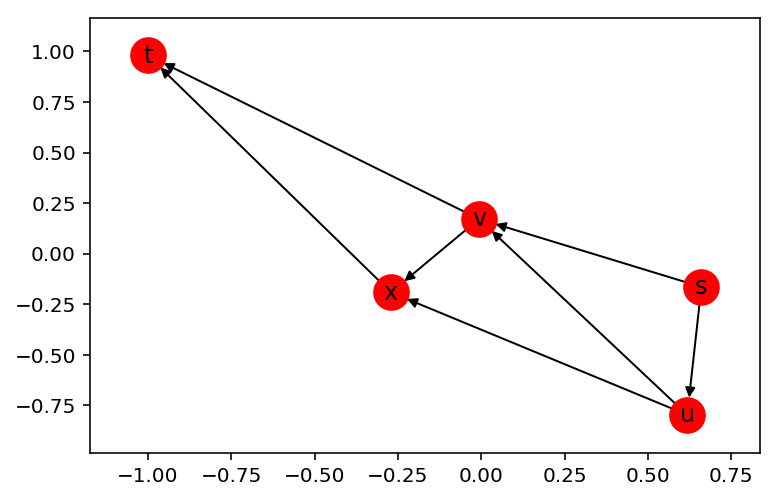

In [10]:
# Максимальынй поток по данным из numpy
graph_from_numpy = GraphFromNumpy()
graph_t1 = graph_from_numpy.return_graph(capacity, weights)
find_max_flow_from_graph(graph_t1, node_dict, 1, 5)

In [11]:
# Поток заданной величины с минимальными затратами
bg_mincost = BroesekerGowenMinCost(weights, capacity, flows, node_dict, 1, 5)
bg_mincost.solve(theta = 25)

Iteration: 1
	Current shortest path μ_1: [1, 2, 3, 5]|['s', 'u', 'v', 't']
[(0, 1), (1, 2), (2, 4)] [18, 15, 17]
	One flow cost for the path d(μ_1): 10.0
	Capacity matrix path μ_1 coordinates: [(0, 1), (1, 2), (2, 4)]
	δ(μ_1): min([18, 15, 17]) = 15
	Checking flow value. Ok. tmp_phi: 15 <= θ: 25. New total_vphi: 15
Total ν(φ): 15
--------------------------------------------------
Iteration: 2
	Current shortest path μ_2: [1, 3, 5]|['s', 'v', 't']
[(0, 2), (2, 4)] [20, 2]
	One flow cost for the path d(μ_2): 11.0
	Capacity matrix path μ_2 coordinates: [(0, 2), (2, 4)]
	δ(μ_2): min([20, 2]) = 2
	Checking flow value. Ok. tmp_phi: 17 <= θ: 25. New total_vphi: 17
Total ν(φ): 17
--------------------------------------------------
Iteration: 3
	Current shortest path μ_3: [1, 2, 4, 5]|['s', 'u', 'x', 't']
[(0, 1), (1, 3), (3, 4)] [3, 20, 14]
	One flow cost for the path d(μ_3): 13.0
	Capacity matrix path μ_3 coordinates: [(0, 1), (1, 3), (3, 4)]
	δ(μ_3): min([3, 20, 14]) = 3
	Checking flow value. 

SystemExit: End of the program

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
# Тестовый пример 2
inf = np.inf
# Матрица пропускных способностей A
capacity = np.array([
                       [0, 9, 7, 0, 0, 0], 
                       [0, 0, 11, 8, 0, 16], 
                       [0,0,0, 6, 7, 0],
                       [0, 0, 0, 0, 9, 13],
                       [0, 0, 0, 0, 0, 7],
                       [0, 0, 0, 0, 0, 0]
                    ])

# Матрица затрат на перевозку d
weights = np.array([
                    [inf, 10, 8, inf, inf, inf],
                    [inf, inf, 10, 14, inf, 19],
                    [inf, inf, inf, 10, 8, inf],
                    [inf, inf, inf, inf, 4, 12],
                    [inf, inf, inf, inf, inf, 7],
                    [inf, inf, inf, inf, inf, inf]
                    ])

# Матрица потоков F
flows = np.zeros((6,6))

# Словарь-декодировщик узлов сети
node_dict = {1:'s', 2:'u', 3:'v', 4:'x', 5:'y', 6:'t'}

(16,
 {1: {2: 9, 3: 7},
  2: {3: 0, 4: 0, 6: 9},
  3: {4: 6, 5: 1},
  4: {5: 0, 6: 6},
  5: {6: 1},
  6: {}},
 {(1, 2), (1, 3)},
 16)

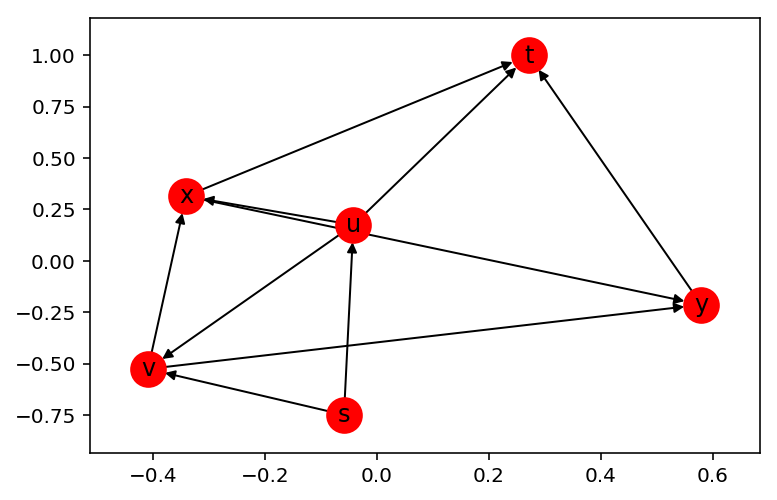

In [13]:
# Максимальынй поток по данным из numpy
graph_from_numpy = GraphFromNumpy()
graph_t2 = graph_from_numpy.return_graph(capacity, weights)
find_max_flow_from_graph(graph_t2, node_dict, 1, 6)

In [14]:
# Поток заданной величины с минимальными затратами
bg_mincost = BroesekerGowenMinCost(weights, capacity, flows, node_dict, 1, 6)
bg_mincost.solve(theta = 0.75*16)

Iteration: 1
	Current shortest path μ_1: [1, 3, 5, 6]|['s', 'v', 'y', 't']
[(0, 2), (2, 4), (4, 5)] [7, 7, 7]
	One flow cost for the path d(μ_1): 23.0
	Capacity matrix path μ_1 coordinates: [(0, 2), (2, 4), (4, 5)]
	δ(μ_1): min([7, 7, 7]) = 7
	Checking flow value. Ok. tmp_phi: 7 <= θ: 12.0. New total_vphi: 7
Total ν(φ): 7
--------------------------------------------------
Iteration: 2
	Current shortest path μ_2: [1, 2, 6]|['s', 'u', 't']
[(0, 1), (1, 5)] [9, 16]
	One flow cost for the path d(μ_2): 29.0
	Capacity matrix path μ_2 coordinates: [(0, 1), (1, 5)]
	δ(μ_2): min([9, 16]) = 9
	Checking flow value. Warning. Possible new ν(φ): 16 > theta: 12.0. Min value set to 5.0. New total_vphi: 12.0
Total ν(φ): 12.0
--------------------------------------------------
Final flows matrix:
[[0 5 7 0 0 0]
 [0 0 0 0 0 5]
 [0 0 0 0 7 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 7]
 [0 0 0 0 0 0]]
Cost: 306.0


SystemExit: End of the program

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
